In [2]:
%matplotlib inline
from astropy.io import ascii
import astropy.coordinates as coord
from astropy import units as u
import matplotlib.pyplot as plt

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
filename = '/Users/yaolun/data/digit_source'
digit = ascii.read(filename)

## convert coordinates of DIGIT protostars into degrees for cross-match with UWIFE

In [4]:
digit_coord = []
for i in range(len(digit)):
    c = coord.SkyCoord(digit['RA'][i]+' '+digit['DEC'][i], unit=(u.hourangle, u.deg))
    digit_coord.append(c)
    print digit['Name'][i], c.ra.degree, c.dec.degree

L1157 309.77625 68.0377777778
L1014 321.03125 49.9858333333
IRAS03301+3111 53.3033333333 31.3567222222
B1-c 53.3245833333 31.1588611111
B1-a 53.3195833333 31.132
IRAS03245+3002 51.9129166667 30.2175277778
L1455-IRS3 52.0016666667 30.1336944444
TMR1 69.8079166667 25.8890555556
TMC1 70.3029166667 25.7766388889
TMC1A 69.8958333333 25.6959722222
L1551-IRS5 67.8920833333 18.1346944444
B335 294.25375 7.56936111111
GSS30-IRS1 246.589166667 -24.3845277778
VLA1623-243 246.61 -24.4083333333
WL12 246.684166667 -24.5801111111
IRS46_44 246.8725 -24.6544722222
RCrA-IRS7C 285.480416667 -36.9547222222
RCrA-IRS5A 285.450416667 -36.9563055556
RCrA-IRS7B 285.485 -36.9578611111
BHR71 180.40125 -65.1480555556
DKCha 193.321666667 -77.1196388889
Elias29 246.789166667 -24.6218333333
IRAM04191+1522 65.4870833333 15.4960833333
IRS63 247.898333333 -24.0248055556
L1448-MM 51.4120833333 30.7348333333
L1489 61.17875 26.3156388889
L1527 69.9745833333 26.0527222222
Serpens-SMM3 277.497083333 1.23380555556
Serpens-SMM

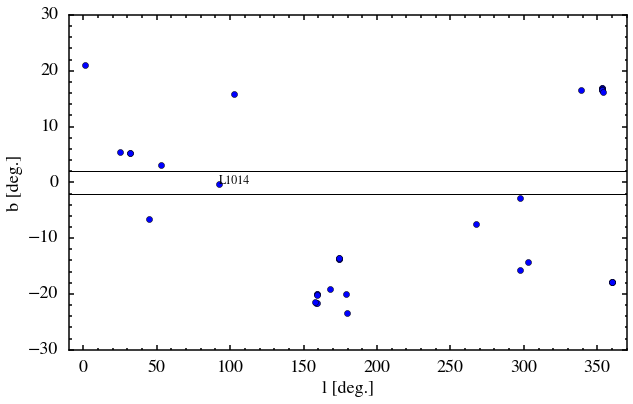

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for i in range(len(digit_coord)):
#     ax.plot([digit_coord[i].ra.degree], [digit_coord[i].dec.degree], 'bo')
    ax.plot([digit_coord[i].galactic.l.degree], [digit_coord[i].galactic.b.degree], 'bo')
    if (digit_coord[i].galactic.b.degree <= 2) and (digit_coord[i].galactic.b.degree > -2):
        ax.annotate(digit['Name'][i],
                    xy=(digit_coord[i].galactic.l.degree,digit_coord[i].galactic.b.degree),
                    xytext=(digit_coord[i].galactic.l.degree,digit_coord[i].galactic.b.degree),
                    fontsize=12)
    
ax.axhline(2, color='k', linestyle='-')
ax.axhline(-2, color='k', linestyle='-')
    
ax.set_xlim([-10,370])
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('l [deg.]', fontsize=18)
ax.set_ylabel('b [deg.]', fontsize=18)

## Get Images from 2MASS image server

### Description of how flux recorded in 2MASS data
The conversion of a 2MASS unit of flux ("dn" for data number, corresponding to the pixel value) is as follows:

m = m_0 - 2.5*log(f)

where f is the background-subtracted flux (in "dn" units), m_0 is the zero point calibration magnitude, and m is the desired (calibrated) magnitude. The zero points are given in the FITS header, with key words JMAGZP, HMAGZP and KMAGZP, respectively; see example below. The extracted photometry was calibrated in this fashion.

<img src='2mass_flux.png'>

In [6]:
from subprocess import Popen, call
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import os
from astropy.io.votable import parse
import urllib

Function to make image

In [7]:
def make_image(filepath, coord, size=0.03, plotname=None, plotdir=None, stretch='log', vmin=None,
               bar_size=30, aper=None, int_unit='MJy/sr', text=None):
    import numpy as np
    import aplpy as apl
    import matplotlib
    import matplotlib.pyplot as plt
    from astropy.io import fits
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    import os

    mag = 1.5

    print coord
    
    im = apl.FITSFigure(filepath,north=True)
    cmap = plt.cm.viridis
    im.show_colorscale(cmap=cmap,stretch=stretch, vmin=vmin)
    
    im.recenter(coord.ra.degree,coord.dec.degree,radius=size)
    im.show_markers(coord.ra.degree, coord.dec.degree, marker='+', c='w', s=120, linewidth=2)
#     im.add_grid()
#     im.grid.set_xspacing(size/5.)
#     im.grid.set_yspacing(size/5.)
#     im.grid.set_color('green')
    im.set_nan_color('black')
    im.tick_labels.set_font(size=18)
    # im.set_grid_alpha(0.2)

    im.add_colorbar()
    im.colorbar.set_font(size=20)
    im.colorbar.set_axis_label_text('Intensity ('+int_unit+')')
    im.colorbar.set_axis_label_font(size=20)
#     im.colorbar.set_frame_color('face')
    im.set_tick_labels_format(xformat='hh:mm:ss',yformat='dd:mm:ss')
#     im.set_tick_labels_format(xformat='ddd.ddddd',yformat='ddd.ddddd')
    im.ticks.set_xspacing(2/60.)
    im.ticks.set_yspacing(1/60.)
    im.axis_labels.set_font(size=20)
    im.ticks.set_linewidth(2)
    
    im.add_scalebar(bar_size/3600.)
    im.scalebar.set_length(bar_size * u.arcsecond)
    im.scalebar.set_label(r'$\rm{'+str(bar_size)+'\,arcsec}$')
    im.scalebar.set_font(size=20, weight='bold')
    im.scalebar.set(linestyle='solid', color='white', linewidth=3)
    
    # print image information
    if text != None:
        im.add_label(0.85, 0.9, text, size='xx-large', weight='bold', relative=True, color='white')
    
    # plot a circular region for aperture
    if aper != None:
        im.show_circles([coord.ra.degree], [coord.dec.degree], [aper/3600.], color='lime', linewidth=3)
    
    if plotdir == None:
        plotdir = os.path.dirname(filepath)
    if plotname == None:
        plotname = raw_input('What is the plot name: ')
        print plotname
        
    im.save(plotdir+'/'+plotname+'.pdf',format='pdf',transparent=True, dpi=300)

### Search on 2MASS image server

In [8]:
objdir = '/Users/yaolun/data/digit_hst/2MASS/'
obj = 'BHR71'
if not os.path.exists(objdir+obj):
    os.mkdir(objdir+obj)

coord = SkyCoord('12 01 36.81 -65 08 49.22', unit=(u.hourangle, u.deg))
size = '0.01'
band = 'H'
run = Popen(['curl','-o', objdir+obj+'/'+obj+'.xml',
             'http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_sia?'+\
             'POS='+str(coord.ra.degree)+','+str(coord.dec.degree)+'&'+\
             'SIZE='+size+'&band='+band+'&FORMAT=image/fits'])
run.communicate()

(None, None)

### parse xml

In [9]:
votable = parse(objdir+obj+'/'+obj+'.xml')
table = votable.get_first_table()
# this url list may contain more than one url.
url = table.array['download'].data

In [10]:
print 'Downloading '+str(len(url))+' file(s)'
filepath = []
for link in url:
    if not os.path.exists(objdir+obj+'/data'):
        os.mkdir(objdir+obj+'/data')
    os.chdir(objdir+obj+'/data')
    urllib.urlretrieve(link, link.split('name=')[1])
    filepath.append(objdir+obj+'/data/'+link.split('name=')[1])

In [12]:
fits.open(filepath[0])[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2   / # of Axes                                    
NAXIS1  =                  512                                                  
NAXIS2  =                 1024                                                  
BLOCKED =                    T / TAPE MAY BE BLOCKED IN MULTIPLES OF 2880       
EXTEND  =                    T / TAPE MAY HAVE STANDARD FITS EXTENSIONS         
ORDATE  = '000214  '             / Observation Ref Date (yymmdd)                
DAYNUM  = '1081    '             / Observation Day Num                          
FN_PRFX = 'h1081074'             / .rdo and .par filename prefix                
TYPE    = 'sci     '             / Scan type: dar flt sci cal tst               
SCANNO  =                   74   / Scan Number                                  
SCANDIR = 's       '        

<SkyCoord (ICRS): (ra, dec) in deg
    (180.403375, -65.14700556)>
INFO

INFO:astropy:Deleting work directory /var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/tmpTUw9A6


: Deleting work directory /var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/tmpTUw9A6 [montage_wrapper.wrappers]
INFO

INFO:astropy:Auto-setting vmin to  5.216e+02
INFO:astropy:Auto-setting vmax to  7.915e+02


: Auto-setting vmin to  5.216e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.915e+02 [aplpy.core]
<SkyCoord (ICRS): (ra, dec) in deg
    (180.403375, -65.14700556)>
INFO

INFO:astropy:Deleting work directory /var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/tmpPj5wQ3


: Deleting work directory /var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/tmpPj5wQ3 [montage_wrapper.wrappers]
INFO

INFO:astropy:Auto-setting vmin to  5.364e+02
INFO:astropy:Auto-setting vmax to  8.423e+02


: Auto-setting vmin to  5.364e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.423e+02 [aplpy.core]


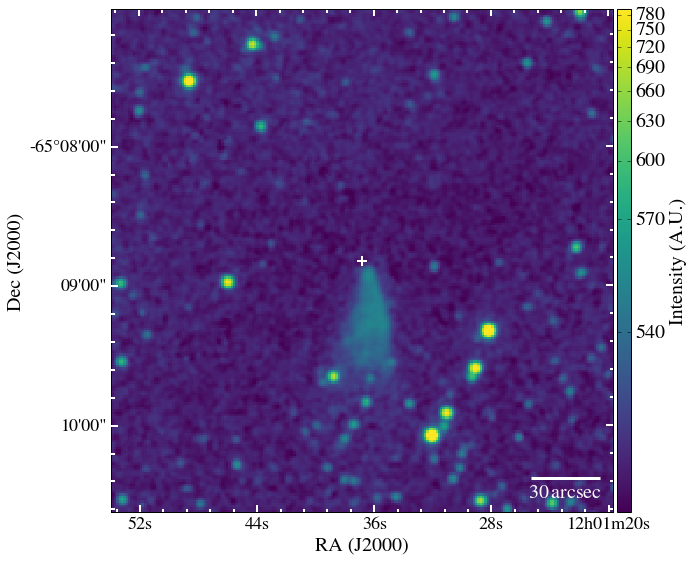

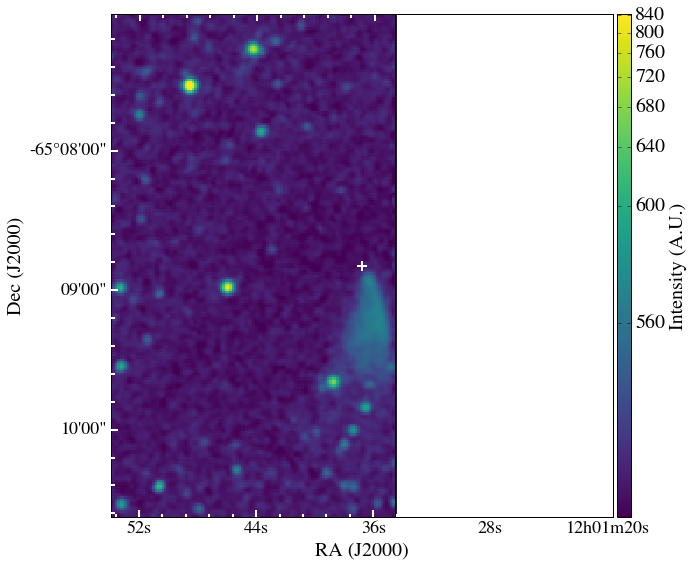

In [24]:
for foo in filepath:
#     int_unit = fits.open(foo)[1].header
    make_image(foo, coord, size=0.03, plotname=os.path.basename(foo).split('.')[0],
               plotdir=objdir+obj+'/data/', stretch='arcsinh', vmin=None,
               bar_size=30, aper=None, int_unit='A.U.', text=None)

In [1]:
import numpy as np
im = fits.open(filepath[0])
skymag, skymag_err = im[0].header['SKYVAL'], im[0].header['SKYSIG']
m0 = im[0].header['MAGZP']
Fnu_m0, Fnu_m0_err = 1024, 20

# convert dn unit to magnitude
im_mag = m0 - 2.5*np.log(im[0].data-skymag)
# convert magnitude to flux (Jy)
im_flux = Fnu_m0 * 10**(im_mag/(-2.5))

# update the FITS and save with another name
# absolute magnitude
im[0].data = im_mag
im.writeto(objdir+obj+'/data/'+os.path.basename(filepath[0]).split('.')[0]+'_mag.fits', clobber=True)
# flux in Jy
im[0].data = im_flux
im.writeto(objdir+obj+'/data/'+os.path.basename(filepath[0]).split('.')[0]+'_flux.fits', clobber=True)

NameError: name 'fits' is not defined

<SkyCoord (ICRS): (ra, dec) in deg
    (180.403375, -65.14700556)>
INFO

INFO:astropy:Deleting work directory /var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/tmp7Wll9a


: Deleting work directory /var/folders/d2/xn0qhb7x2p7gqlvz33zdqrsh0000gn/T/tmp7Wll9a [montage_wrapper.wrappers]
INFO

INFO:astropy:Auto-setting vmax to  3.387e+01


: Auto-setting vmax to  3.387e+01 [aplpy.core]


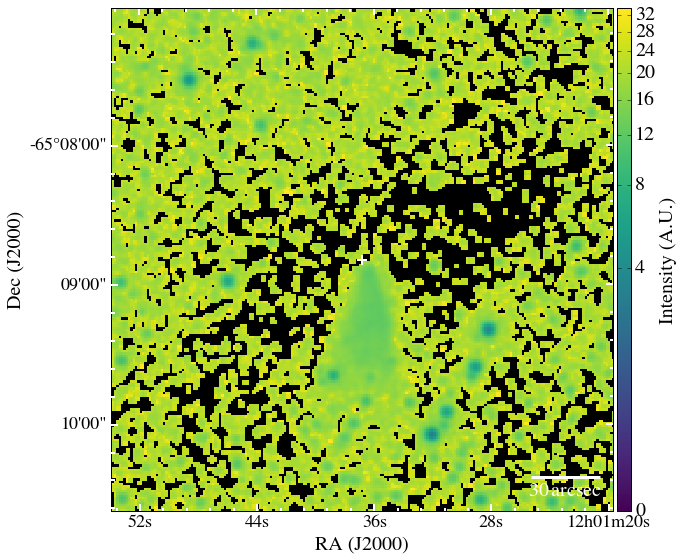

In [32]:
make_image(objdir+obj+'/data/'+os.path.basename(filepath[0]).split('.')[0]+'_flux.fits', coord, size=0.03, 
           plotname=os.path.basename(foo).split('.')[0]+'_flux',
           plotdir=objdir+obj+'/data/', stretch='arcsinh', vmin=0,
           bar_size=30, aper=None, int_unit='A.U.', text=None)

### Aperture Photometry

In [40]:
from photutils import aperture_photometry as ap
from photutils import CircularAperture
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import wcs

im = fits.open(objdir+obj+'/data/'+os.path.basename(filepath[0]).split('.')[0]+'_flux.fits')
coord = SkyCoord('12 01 36.3 -65 08 53.0', unit=(u.hourangle, u.deg))
aper_rad = 3.

w = wcs.WCS(im[0].header)
pixcoord = w.wcs_world2pix(coord.ra.degree, coord.dec.degree, 1)
pix2arcsec = abs(im[0].header['CDELT1'])*3600
aperture = CircularAperture((pixcoord[0],pixcoord[1]), r=aper_rad/pix2arcsec)

# get rid of NaN
im_data = np.nan_to_num(im[0].data)
phot_table = ap(im_data, aperture) 
print phot_table['aperture_sum']

  aperture_sum 
               
---------------
0.0448503853538


In [43]:
(abs(im[0].header['CDELT1'])*3600 / 0.13)

1.0000000242